Import the neccessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

Data Acquisition and Initial Setup

In [2]:
# Define the stock ticker and date range
TICKER = "MA" # Mastercard Incorporated
START_DATE = "2018-01-01"
END_DATE = "2023-12-31" # Fetches 5 years of historical data

In [3]:
print(f"===== Downloading Data for {TICKER} =====")
# Download the historical stock data using yfinance
try:
    data = yf.download(TICKER,start=START_DATE,end=END_DATE)
except Exception as e:
    # Handle potential connection or ticker errors gracefully
    print(f"Error downloading data: {e}")
    exit()

===== Downloading Data for MA =====


C:\Users\Dell\AppData\Local\Temp\ipykernel_5816\853863136.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER,start=START_DATE,end=END_DATE)
[*********************100%***********************]  1 of 1 completed


In [4]:
# Check if data was successdully downloaded
if data.empty:
    print("No data retrived. Check the ticker or date range.")
    exit()

In [5]:
print("===== Data Informmation =====")
print(data.info())

===== Data Informmation =====
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2018-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   (Close, MA)   1509 non-null   float64
 1   (High, MA)    1509 non-null   float64
 2   (Low, MA)     1509 non-null   float64
 3   (Open, MA)    1509 non-null   float64
 4   (Volume, MA)  1509 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.7 KB
None


In [6]:
data.to_csv("mastercard_stock_data.csv",index=False)

In [10]:
data

Price,Close,High,Low,Open,Volume
Ticker,MA,MA,MA,MA,MA
Date,,,,,
2018-01-02,145.276031,146.710526,144.520523,145.371656,3168900
2018-01-03,147.102600,147.255602,145.515090,145.639403,3732400
2018-01-04,149.005707,150.526267,147.580785,147.791164,3247200
2018-01-05,152.094696,152.094696,149.369165,149.378723,2747700
2018-01-08,152.554459,153.713431,151.414632,151.893550,3143100
...,...,...,...,...,...
2023-12-22,419.252075,422.286989,418.125092,419.894639,1759000
2023-12-26,418.826996,420.853550,418.115225,420.141779,1258200


Feature Engineering and Target Variable Creation

In [11]:
print("----- Feature Engineering ------")
# Create a Target Variable (y)
# The target variable (y) for classification:
# 1 if the Close price goes UP tomorrow, 0 otherwise (Down or Stays the Same)
# We use "shift(-1)" to align the "next day's" closing price with the current day's features
data["Price_Up"] = (data["Close"].shift(-1) > data["Close"]).astype(int)

----- Feature Engineering ------


In [12]:
# Create Technical Features (X)

# Simple Moving Averages (SMAs)
# These features help the model identify short-term trends
data["SMA_5"] = data["Close"].rolling(window=5).mean() # 5-day SMA
data["SMA_20"] = data["Close"].rolling(window=20).mean()  # 20-day SMA

In [13]:
# Daily Price Change (Momentum)
# The percentage change in the Closing price helps quantify volatility/momentum
data["Daily_Return"] = data["Close"].pct_change()

In [14]:
# Volatility Measure (Standard Deviation)
# Standard deviation of returns over a window (e.g, 10 days) to measure risk
data["Volatility_10"] = data["Daily_Return"].rolling(window=10).std()

In [15]:
# Price-to-Volume Ratio
# A Simple feature comparing the average price movement relative to trading volume
data["Price_Volume_Ratio"] = data["Close"] * data["Volume"]

In [16]:
# Drop the last row, as it will have NaN target value (no next day's price)
data.dropna(inplace=True)

In [17]:
# Define the features (X) and the target (y)
FEATURES = ["Close","SMA_5","SMA_20","Daily_Return","Volatility_10","Price_Volume_Ratio"]
X = data[FEATURES]
y = data["Price_Up"]

print(f"Final dataset shape after dropping NaNs: {data.shape}")
print(f"Feature set size: {X.shape}, Target set size: {y.shape}")

Final dataset shape after dropping NaNs: (1490, 11)
Feature set size: (1490, 6), Target set size: (1490,)


Data Visualization before training

----- Data Visualization (Pre-Training) -----


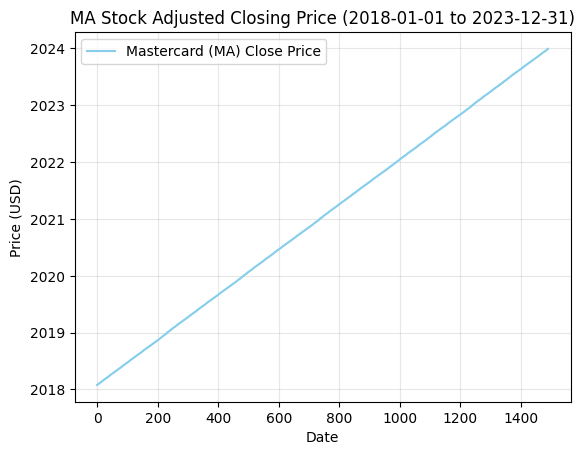

In [18]:
print("----- Data Visualization (Pre-Training) -----")

# Plot 1: Closing price with Trend over time
plt.Figure(figsize=(14,6))
# Plot the adjusted closing price over time
plt.plot(data.index,data=["Close"],label="Mastercard (MA) Close Price",color="skyblue")
plt.title(f"{TICKER} Stock Adjusted Closing Price ({START_DATE} to {END_DATE})")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_20848\3226757505.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y,palette='viridis')


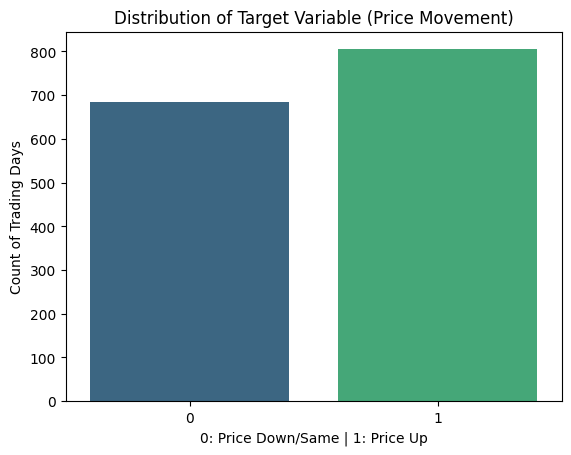

In [19]:
# Plot 2: Target Variable Distribution (Up/Down Classification)
plt.Figure(figsize=(7,5))
# Count the occurrence of "1" (Price Up) and "0" (Price Down/Same)
sns.countplot(x=y,palette='viridis')
plt.title("Distribution of Target Variable (Price Movement)")
plt.xlabel("0: Price Down/Same | 1: Price Up")
plt.ylabel("Count of Trading Days")
plt.show()

Data Splitting

In [20]:
print("----- Preprocessing Data -----")

# Split the data into training and testing sets (80% train, 20% test)
# shuffle=False is cruical for time-series data into maintain temporal order
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False,random_state=42)

----- Preprocessing Data -----


Data Scaling

In [21]:
# Initialize the Standard Scaler
# StandardScaler standardizes features by removing the mean and scaling to unit variance
scaler = StandardScaler()

# Fit the scaler only on the training data to prevent data leakage from the test set
X_train_scaled = scaler.fit(X_train)

# Apply the fitted scaler to transform both training and testing data
X_test_scaled = scaler.transform(X_test)

Model Comparison

In [22]:
print("----- Training and Comparing Classificaton Models -----")

# Define a list of models to compare
models = [
    ("Logistic Regression",LogisticRegression(random_state=42,solver="liblinear")),
    ("K-Nearest Neighbors",KNeighborsClassifier()),
    ("Random Forest",RandomForestClassifier(random_state=42)),
    ("Support Vector Machine (Linear)",SVC(kernel="linear",random_state=42)),
    ("Gaussian Naive Bayes",GaussianNB())
]

results = {} # Dictionary to store accuracy results

----- Training and Comparing Classificaton Models -----


In [ ]:
# Iterate through all models, train, and evaluate them
for name, model in models:
    # Train the model on the scaled training data
    model.fit(X_train_scaled, y_train)

    # Predict the target variable on the scaled test data
    y_pred = model.predict(X_test_scaled)

    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    # Print the detailed classification report for each model
    print(f"\nModel: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    # The classification report shows Precision, Recall, and F1-score for each class (0 and 1)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# Find the best performing model based on accuracy
best_model_name = max(results, key=results.get)
print(f"\n--- BEST INITIAL MODEL: {best_model_name} (Accuracy: {results[best_model_name]:.4f}) ---")

Hyperparameter Tuning (For Best Model)

In [ ]:
print("----- Hyperparameter Tuning (Optimizing Random Forest) -----")

# We choose Random Forest for tuning as it generally performs well on financial data
# Re-initialize the best model for tuning
best_model = RandomForestClassifier(random_state=42)

# Define the grid of hyperparameters to search over
# n_estimatos: Number of trees on the forest
# max_depth: Maximum depth of the tree
# min_samples_leaf: Minimum number of samples required to be at a leaf node
param_grid = {
    "n_estimators":[100,200],
    "max_depth":[50,10,None], # None means nodes are expanded until all leaves are pure
    "min_samples_leaf":[1,5]
}

In [ ]:
# Initialize GridSearchCV
# GridSearchCV performs an exhaustive search over the specified parameter values.
# cv=3 means 3-fold cross-validation is used on the training set
grid_search = GridSearchCV(
    estimator=best_model,
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1 # Use all availabl cores for faster processing
)

In [ ]:
# Fit GridSearchCV to the scaled training data
grid_search.fit(X_train_scaled,y_train)

In [ ]:
# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
tuned_model = grid_search.best_estimator_

In [ ]:
print("----- Tuning Results -----")
print(f"Best Hyperparameters found: {best_params}")
print(f"Best cross-validation accuracy: {best_score:.4f}")

In [ ]:
# Evaluate the tuned model on the test set
y_tuned_pred = tuned_model.predict(X_test_scaled)
final_accuracy = accuracy_score(y_test,y_tuned_pred)

In [ ]:
print(f"Final Accuracy of Tuned Model on the Test Set: {final_accuracy:.4f}")
print("Final Classification Report of the Tuned Model")
print(classification_report(y_test,y_tuned_pred))

Visualization Afer Training

In [ ]:
print("----- Data Visualization (Post-Training) -----")

# Plot1: Model Comparison Bar Chart
plt.figure(figsize=(10,6))
# Create a DataFrame from the results dictionary for easy plotting
results_df = pd.DataFrame(results.items(),columns=["Model","Accuracy"])
sns.barplot(x="Accuracy",y="Model",data=results_df,palette="Spectral")
plt.title("Comparsion of Initial Model Accuracies")
plt.xlabel("Accuracy Score")
plt.ylabel("Classification Model")
plt.xlim(0.4,0.6) # Set limit to better highligh differences
plt.show()

In [ ]:
# Plot 2: Confusion Matrix for the Tuned Best Model
# Confusion matrix shows the count of correct and incorrect predictions.
# True Negative (0,0), False Positive (0,1), False Negative (1,0), True Positive (1,1)
cm = confusion_matrix(y_test, y_tuned_pred)

plt.figure(figsize=(8, 6))
# Create a heatmap visualization for the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Down', 'Predicted Up'],
            yticklabels=['Actual Down', 'Actual Up'])
plt.title(f'Confusion Matrix for Tuned {best_model_name} Model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

Prediction Function for new data

In [ ]:
# Function to simulate new data prediction
def predict_new_day(adj_close, sma_5, sma_20, daily_return, volatility_10, price_volume_ratio, model, scaler):
    """
    Takes new feature inputs, preprocesses them, and makes a price direction prediction.
    """
    # Create a DataFrame for the new input data
    new_data = pd.DataFrame({
        'Adj Close': [adj_close],
        'SMA_5': [sma_5],
        'SMA_20': [sma_20],
        'Daily_Return': [daily_return],
        'Volatility_10': [volatility_10],
        'Price_Volume_Ratio': [price_volume_ratio]
    })

    # Transform the new data using the FITTED scaler
    new_data_scaled = scaler.transform(new_data)

    # Make the prediction
    prediction = model.predict(new_data_scaled)[0]
    prediction_proba = model.predict_proba(new_data_scaled)[0]

    # Interpret the prediction result
    result = "UP (Class 1)" if prediction == 1 else "DOWN/SAME (Class 0)"
    confidence = prediction_proba[prediction]

    print("\n--- NEW PREDICTION RESULT ---")
    print(f"Input Features: {new_data.iloc[0].to_dict()}")
    print(f"Predicted Price Direction: {result}")
    print(f"Model Confidence: {confidence:.2f}")

# Example of how to use the prediction function with sample data
# (In a real scenario, these values would come from the latest market data)
print("\n--- 9. Example New Prediction ---")
# Using the last row of the test set's features as a representative "new" day
last_day_features = X_test.iloc[-1].values

predict_new_day(
    adj_close=last_day_features[0],
    sma_5=last_day_features[1],
    sma_20=last_day_features[2],
    daily_return=last_day_features[3],
    volatility_10=last_day_features[4],
    price_volume_ratio=last_day_features[5],
    model=tuned_model,
    scaler=scaler
)